In [138]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import SparsePCA, PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Load data

In [139]:
# Constants
DIR_PATH = '../Consolidated_Features'
SUBJECT_LIST = [
    "3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
    "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
    "3153", "3154", "3155", "3156", "3158", "3159", "3160", "3162", "6037", "6038", 
    "6043", "6044", "6045", "6046", "6047", "6048", "6049"
]
NUM_STIMULI = 5
STIMULUS_TYPES = ['Rest', 'Reading', 'SpeechPrep', 'Speech', 'Recovery']
NUM_FEATURES = 5
FEATURE_TYPES = ['HR', 'PAT', 'PEP', 'PPGamp', 'PTTrecip']

# List to store dataframes for MI subjects
dataframes_mi = []

# List to store dataframes for healthy control subjects
dataframes_ht = []

# List to store dataframes for all subjects
dataframes_all = []

# Variables to track index of MI, healthy control, and all subjects
sub_mi = -1
sub_ht = -1
sub_all = -1

# Loop through all subjects
for sub in os.listdir(DIR_PATH):
    subject_id = int(sub[3:])  # Extract subject ID from directory name

    if str(subject_id) in SUBJECT_LIST:

        # Check if the subject ID belongs to MI subjects
        if str(subject_id).startswith('3'):
            sub_mi += 1
            dataframes_mi.append([])

            # Loop through stimuli
            for stim in range(NUM_STIMULI):
                dataframes_mi[sub_mi].append([])

                # Loop through features
                for feat in range(NUM_FEATURES):
                    dataframes_mi[sub_mi][stim].append([])
                    feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                    data = pd.read_csv(feat_load)
                    dataframes_mi[sub_mi][stim][feat] = data.values
        
        # Check if the subject ID belongs to healthy control subjects
        elif str(subject_id).startswith('6'):
            sub_ht += 1
            dataframes_ht.append([])

            # Loop through stimuli
            for stim in range(NUM_STIMULI):
                dataframes_ht[sub_ht].append([])

                # Loop through features
                for feat in range(NUM_FEATURES):
                    dataframes_ht[sub_ht][stim].append([])
                    feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                    data = pd.read_csv(feat_load)
                    dataframes_ht[sub_ht][stim][feat] = data.values
        
        # For all subjects
        sub_all += 1
        dataframes_all.append([])

        # Loop through stimuli
        for stim in range(NUM_STIMULI):
            dataframes_all[sub_all].append([])

            # Loop through features
            for feat in range(NUM_FEATURES):
                dataframes_all[sub_all][stim].append([])
                feat_load = os.path.join(DIR_PATH, 'sub' + str(subject_id), 'stim' + str(stim) + '_' + FEATURE_TYPES[feat] + '.csv')
                data = pd.read_csv(feat_load)
                dataframes_all[sub_all][stim][feat] = data.values

print("Data loading completed.")

Data loading completed.


# Normalize to baseline

In [140]:
# %% Baseline correction (normalization)

# Determine MI (Myocardial Infarction) vs. HT (Healthy Control) status based on subject identifier
mi_subjects = ["3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
               "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
               "3153", "3154", "3155", "3156", "3158", "3159", "3160", "3162"]

# Healthy Control subjects
ht_subjects = ["6037", "6038", "6043", "6044", "6045", "6046", "6047", "6048", "6049"]

# Initialize lists to store mean difference, normalized data, and labels
mean_difference_all = []  # Stores the mean difference between feature and baseline for all subjects, stimuli, and features
normalized_data_all = []  # Stores the normalized data for all subjects, stimuli, and features
labels_all = []  # Stores the labels for all subjects, stimuli, and features

# Number of data points and half of it
num_data_points = 80  # Total number of data points
data_points_half = round(num_data_points / 2)  # Half of the total number of data points

# Loop through each subject
for subject_index, subject_id in enumerate(SUBJECT_LIST):
    normalized_data_subject = []  # Stores the normalized data for the current subject
    labels_subject = []  # Stores the labels for the current subject

    # Loop through each stimulus
    for stimulus_index in range(NUM_STIMULI):
        normalized_data_stimulus = []  # Stores the normalized data for the current stimulus
        labels_stimulus = []  # Stores the labels for the current stimulus

        # Loop through each feature
        for feature_index in range(NUM_FEATURES):
            baseline_data = dataframes_all[subject_index][0][feature_index][:, 1]  # Baseline data
            baseline_midpoint = baseline_data[len(baseline_data) // 2 - data_points_half:len(baseline_data) // 2 + data_points_half]  # Midpoint of baseline data
            feature_data = dataframes_all[subject_index][stimulus_index][feature_index][:, 1]  # Feature data
            feature_midpoint = feature_data[len(feature_data) // 2 - data_points_half:len(feature_data) // 2 + data_points_half]  # Midpoint of feature data

            # Calculate mean difference between feature and baseline
            mean_difference = (np.mean(feature_midpoint) - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)
            mean_difference_all.append(mean_difference)

            # Normalize the data and assign labels

            if stim == 0:
                normalized_data = (baseline_midpoint - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)

                if subject_id in mi_subjects:
                    labels = np.zeros_like(normalized_data)  # Assign label 0

                else:
                    labels = np.ones_like(normalized_data)  # Assign label 1
            else:
                normalized_data = (feature_midpoint - np.mean(baseline_midpoint)) / np.mean(baseline_midpoint)
                
                if subject_id in mi_subjects:
                    labels = np.zeros_like(normalized_data)  # Assign label 0
                
                else:
                    labels = np.ones_like(normalized_data)  # Assign label 1

            normalized_data_stimulus.append(normalized_data)
            labels_stimulus.append(labels)

        normalized_data_subject.append(normalized_data_stimulus)
        labels_subject.append(labels_stimulus)

    normalized_data_all.append(normalized_data_subject)
    labels_all.append(labels_subject)

c:\Users\dyzha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dyzha\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


## Get normalized data and labels for SpeechPrep for all features

In [141]:
# Initialize aggregated data and labels specifically for the "Speech Prep" stimulus
aggregated_data_speech_prep = []  # Stores the aggregated normalized data for all features for "Speech Prep"
aggregated_labels_speech_prep = []  # Stores the aggregated labels for all features for "Speech Prep"

for feature_index in range(NUM_FEATURES):
    aggregated_data_feature = []  # Temporary list to aggregate normalized data for the current feature for "Speech Prep"
    aggregated_labels_feature = []  # Temporary list to aggregate labels for the current feature for "Speech Prep"

    # Loop through each subject
    for subject_index in range(len(SUBJECT_LIST)):
        # Extend the temporary lists with data and labels for the current feature and subject for "Speech Prep"
        aggregated_data_feature.extend(normalized_data_all[subject_index][2][feature_index])  # Assuming index 2 corresponds to "Speech Prep"
        aggregated_labels_feature.extend(labels_all[subject_index][2][feature_index])  # Assuming index 2 corresponds to "Speech Prep"

    # Append the aggregated data and labels for the current feature to the overall lists for "Speech Prep"
    aggregated_data_speech_prep.append(aggregated_data_feature)
    aggregated_labels_speech_prep.append(aggregated_labels_feature)

# Determine the minimum length among all lists in data_all_1
min_length_data = min(len(lst) for lst in aggregated_data_speech_prep)

# Truncate each inner list in data_all_1 to have the minimum length
data_all_1_truncated = [lst[:min_length_data] for lst in aggregated_data_speech_prep]

# Convert the truncated list of lists to a Numpy array
data_all_1_array = np.array(data_all_1_truncated)

# Reshape the Numpy array to have 5 columns
num_columns = 5
data_all_1_array = data_all_1_array.reshape(-1, num_columns)

# Determine the minimum length among all lists in data_y_all_1
min_length_data_y = min(len(lst) for lst in aggregated_labels_speech_prep)

# Truncate each inner list in data_y_all_1 to have the minimum length
data_y_all_1_truncated = [lst[:min_length_data_y] for lst in aggregated_labels_speech_prep]

# Convert the truncated list of lists to a Numpy array
data_y_all_1_array = np.array(data_y_all_1_truncated)

# Reshape the Numpy array to have 5 columns
data_y_all_1_array = data_y_all_1_array.reshape(-1, num_columns)

# Extract features and labels
feats = data_all_1_array[:, :]
X = feats
labels = data_y_all_1_array[:, 0]
y = labels

## Remove outliers

In [142]:
# Calculate z-scores for each feature
z_scores = np.abs((feats - np.mean(feats, axis=0)) / np.std(feats, axis=0))

# Define a threshold for z-score to identify outliers
threshold = 3

# Find indices of outliers
outlier_indices = np.where(z_scores > threshold)

# Remove outliers
feats_cleaned = np.delete(feats, outlier_indices[0], axis=0)
labels_cleaned = np.delete(labels, outlier_indices[0])

feats_upc = PCA(n_components=5).fit_transform(feats_cleaned)
feats_spc = PCA(n_components=5).fit_transform(StandardScaler().fit_transform(feats_cleaned))

X = feats_cleaned
y = labels_cleaned

## Apply PCA and sPCA

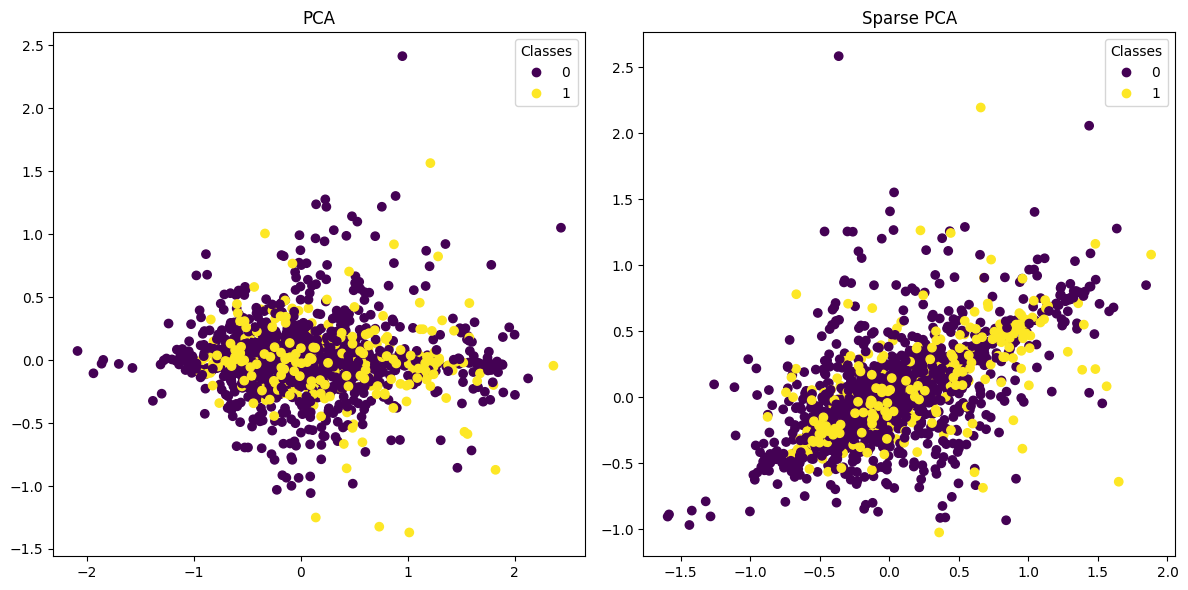

In [152]:
# PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

# Sparse PCA
spca = SparsePCA(n_components=3)
spca.fit(X)
X_spca = spca.transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

scatter_pca = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, label='PCA')
axes[0].set_title('PCA')

scatter_spca = axes[1].scatter(X_spca[:, 0], X_spca[:, 1], c=y, label='Sparse PCA')
axes[1].set_title('Sparse PCA')

axes[0].legend(*scatter_pca.legend_elements(), title='Classes')
axes[1].legend(*scatter_spca.legend_elements(), title='Classes')

plt.tight_layout()
plt.show()

# Apply clustering

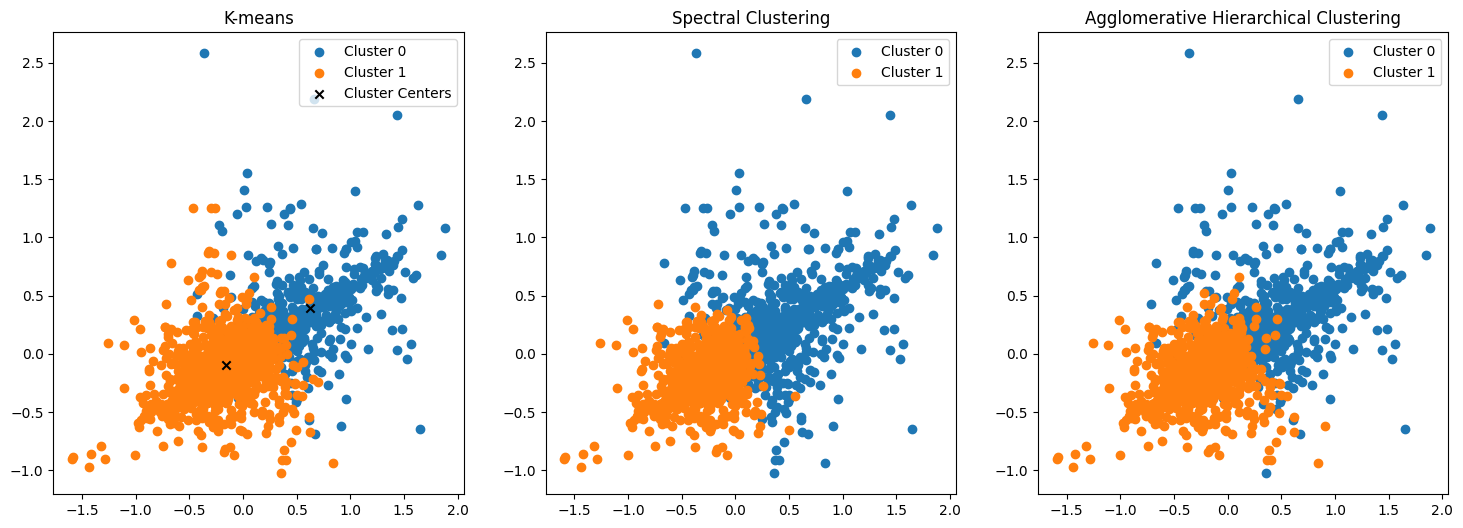

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

NUM_CLUSTERS = 2

# Kmeans
kmeans = KMeans(n_clusters=NUM_CLUSTERS)

kmeans.fit(X_spca)

cluster_labels = kmeans.labels_

cluster_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[kmeans_labels == i]
    axes[0].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

axes[0].scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='x', label='Cluster Centers')
axes[0].set_title('K-means')
axes[0].legend()

# Apply Spectral Clustering
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels_sc = sc.fit_predict(X_spca)

for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[cluster_labels_sc == i]
    axes[1].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

axes[1].set_title('Spectral Clustering')
axes[1].legend()

# Agglomerative Hierarchical Clustering
agg_cluster = AgglomerativeClustering(n_clusters=2)
cluster_labels_agg = agg_cluster.fit_predict(X_spca)

for i in range(NUM_CLUSTERS):
    cluster_points = X_spca[cluster_labels_agg == i]
    axes[2].scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

axes[2].set_title('Agglomerative Hierarchical Clustering')
axes[2].legend()

### Metrics

In [145]:
comparison_results = [1 if model_label == real_label else 0 for model_label, real_label in zip(kmeans_labels, y)]
acc = np.mean(comparison_results)
silhouette = silhouette_score(X_spca, kmeans_labels)
ch_score = calinski_harabasz_score(X_spca, kmeans_labels)

print('Accuracy: ', acc)
print('Silhouette score: ', silhouette)
print('Calinski-Harabasz score', ch_score)

Accuracy:  0.23912159414396095
Silhouette score:  0.5197765569346166
Calinski-Harabasz score 2011.2616714903436


In [147]:
comparison_results = [1 if model_label == real_label else 0 for model_label, real_label in zip(cluster_labels_sc, y)]
acc = np.mean(comparison_results)
silhouette = silhouette_score(X_spca, cluster_labels_sc)
ch_score = calinski_harabasz_score(X_spca, cluster_labels_sc)

print('Accuracy: ', acc)
print('Silhouette score: ', silhouette)
print('Calinski-Harabasz score', ch_score)

Accuracy:  0.379015860105734
Silhouette score:  0.41160860922113834
Calinski-Harabasz score 1802.6861396933557


In [149]:
comparison_results = [1 if model_label == real_label else 0 for model_label, real_label in zip(cluster_labels_agg, y)]
acc = np.mean(comparison_results)
silhouette = silhouette_score(X_spca, cluster_labels_agg)
ch_score = calinski_harabasz_score(X_spca, cluster_labels_agg)

print('Accuracy: ', acc)
print('Silhouette score: ', silhouette)
print('Calinski-Harabasz score', ch_score)

Accuracy:  0.3310288735258235
Silhouette score:  0.4429702902160031
Calinski-Harabasz score 1878.5875394303962
